# Exponentail Weights: Rolling and Expanding Windows
25 March 2024  
Conda environment: `time-series`

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import pandas as pd

from statsmodels.tsa.seasonal import MSTL

In [2]:
# Configs
# Plot configs:
sns.set_context("paper", font_scale= 1.5)
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False
plotsize = (22, 5)
plt.rcParams['figure.figsize'] = plotsize
# Pandas config
pd.options.display.float_format = '{:,.4f}'.format
pd.options.display.max_columns = 200

In [13]:
### Functions
def exponentail_weights(alpha:float, window_size: int) -> np.array:
    """Compute the exponential weights for any input alpha and window size.
    Alpha value: the alpha value of Simple Exponential Smoothing is a good start (from statsmodels).
    Args:
        alpha (float): Alpha parameter (decay rate): 0 < alpha > 1
        window_size (int): For example 12.
    Returns:
        np.array: Obtain exponentail weights.
    """
    # Initialise weights
    weights = np.ones(window_size)
    for ix in range(window_size):
        weights[ix] = (1-alpha)**(window_size-1-ix)
    return weights

def exponential_weighted_mean(x: np.array) -> np.array:
    """Exponential weighted mean.
    Args:
        x (np.array): input array
    Returns:
        np.array: Exponential weighted mean
    """
    weights = exponentail_weights(alpha=0.05, window_size=len(x))
    return (weights * x).sum() / weights.sum()

## 1) Input data

In [4]:
data = pd.read_csv(
    "../Datasets/victoria_electricity_demand.csv",
    usecols=["demand", "temperature", "date_time"],
    index_col=["date_time"],
    parse_dates=["date_time"],
)

# For this demo we will use a subset of the data
data = data.loc["2010":]
data

,demand,temperature
date_time,,
2010-01-01 00:00:00,"8,314.4487",21.5250
2010-01-01 01:00:00,"8,267.1873",22.4000
2010-01-01 02:00:00,"7,394.5284",22.1500
2010-01-01 03:00:00,"6,952.0475",21.8000
2010-01-01 04:00:00,"6,867.1996",20.2500
...,...,...
2015-02-28 19:00:00,"9,596.7771",28.3500
2015-02-28 20:00:00,"8,883.2303",22.2000
2015-02-28 21:00:00,"8,320.2605",18.9000


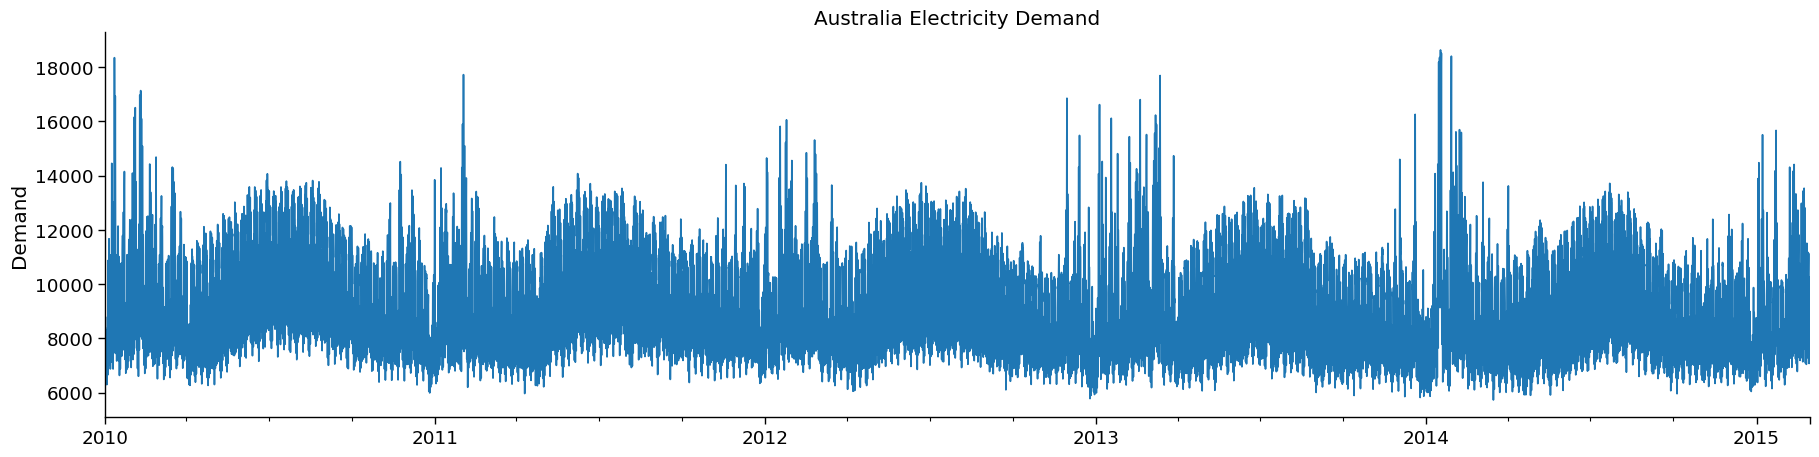

In [5]:
data["demand"].plot()

plt.title("Australia Electricity Demand")
plt.ylabel("Demand")
plt.xlabel("")
plt.show()

## 2) Exponential weights: Rolling windows
When using exponential weights it is more common to use expanding windows, instead of rolling windows.

In [14]:
df = data.copy(deep=True)
exponentail_weights(alpha=0.05, window_size=12)

array([0.56880009, 0.59873694, 0.63024941, 0.66342043, 0.6983373 ,
       0.73509189, 0.77378094, 0.81450625, 0.857375  , 0.9025    ,
       0.95      , 1.        ])

In [15]:
# Exponential weights: for Rolling window mean
result = (
    df["demand"]
    .rolling(window=24*7) # Pick window size.
    .agg(["mean", exponential_weighted_mean]) # Pick statistics.
    .shift(freq="1H") # Lag by 1 hour to avoid data leakage.  
).add_prefix("demand_window_168_")

df = df.join(result, how="left")
df

,demand,temperature,demand_window_168_mean,demand_window_168_exponential_weighted_mean
date_time,,,,
2010-01-01 00:00:00,"8,314.4487",21.5250,NaN,NaN
2010-01-01 01:00:00,"8,267.1873",22.4000,NaN,NaN
2010-01-01 02:00:00,"7,394.5284",22.1500,NaN,NaN
2010-01-01 03:00:00,"6,952.0475",21.8000,NaN,NaN
2010-01-01 04:00:00,"6,867.1996",20.2500,NaN,NaN
...,...,...,...,...
2015-02-28 19:00:00,"9,596.7771",28.3500,"9,670.4635","9,253.6344"
2015-02-28 20:00:00,"8,883.2303",22.2000,"9,654.6168","9,270.7675"
2015-02-28 21:00:00,"8,320.2605",18.9000,"9,638.0186","9,251.3654"


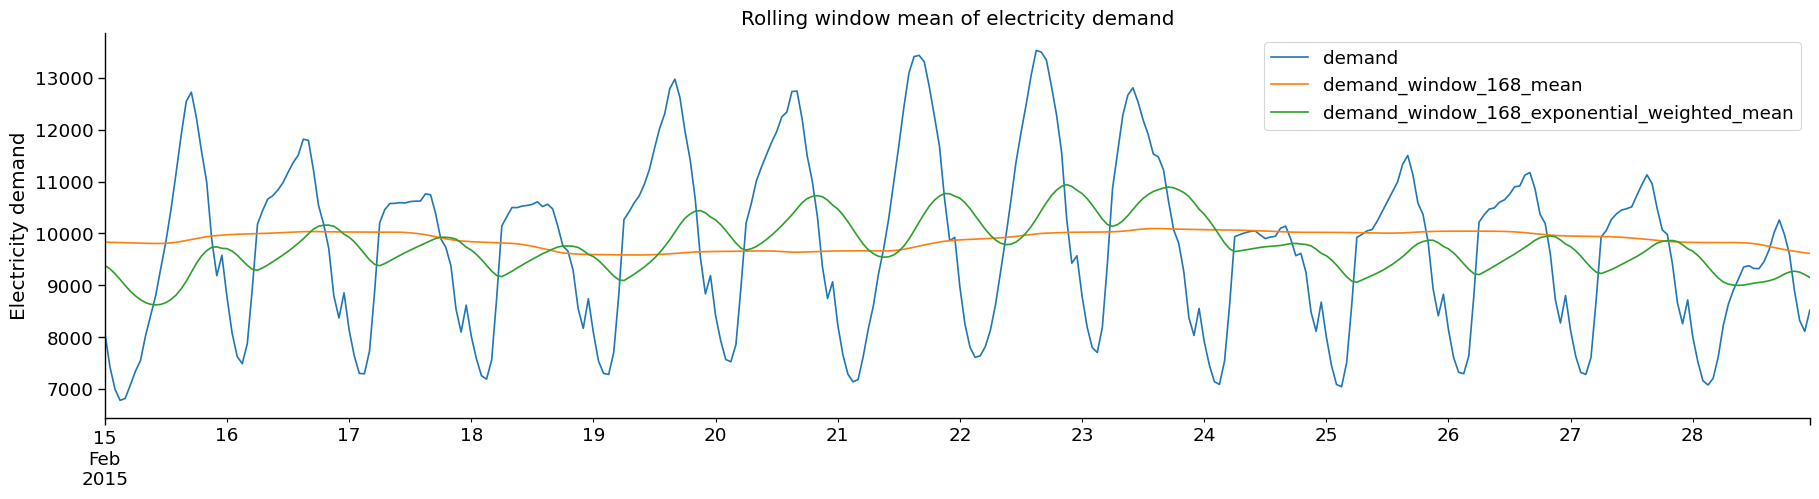

In [17]:
cols = ["demand", "demand_window_168_mean", "demand_window_168_exponential_weighted_mean"]

ax = (
    df.iloc[-24 * 7 * 2 :] # Let's look at the last 2 weeks of data
        .loc[:, cols] # Filter to columns of interest
        .plot()
    )  

ax.set_title("Rolling window mean of electricity demand")
ax.set_ylabel("Electricity demand")
ax.set_xlabel("")

plt.show()

### 2.1) De-trend the data

In [18]:
mstl = MSTL(
    df["demand"], 
    periods=(24, 24 * 7), # Remove daily and weekly seasonality
    stl_kwargs={"seasonal_deg": 0}
        )
res = mstl.fit()

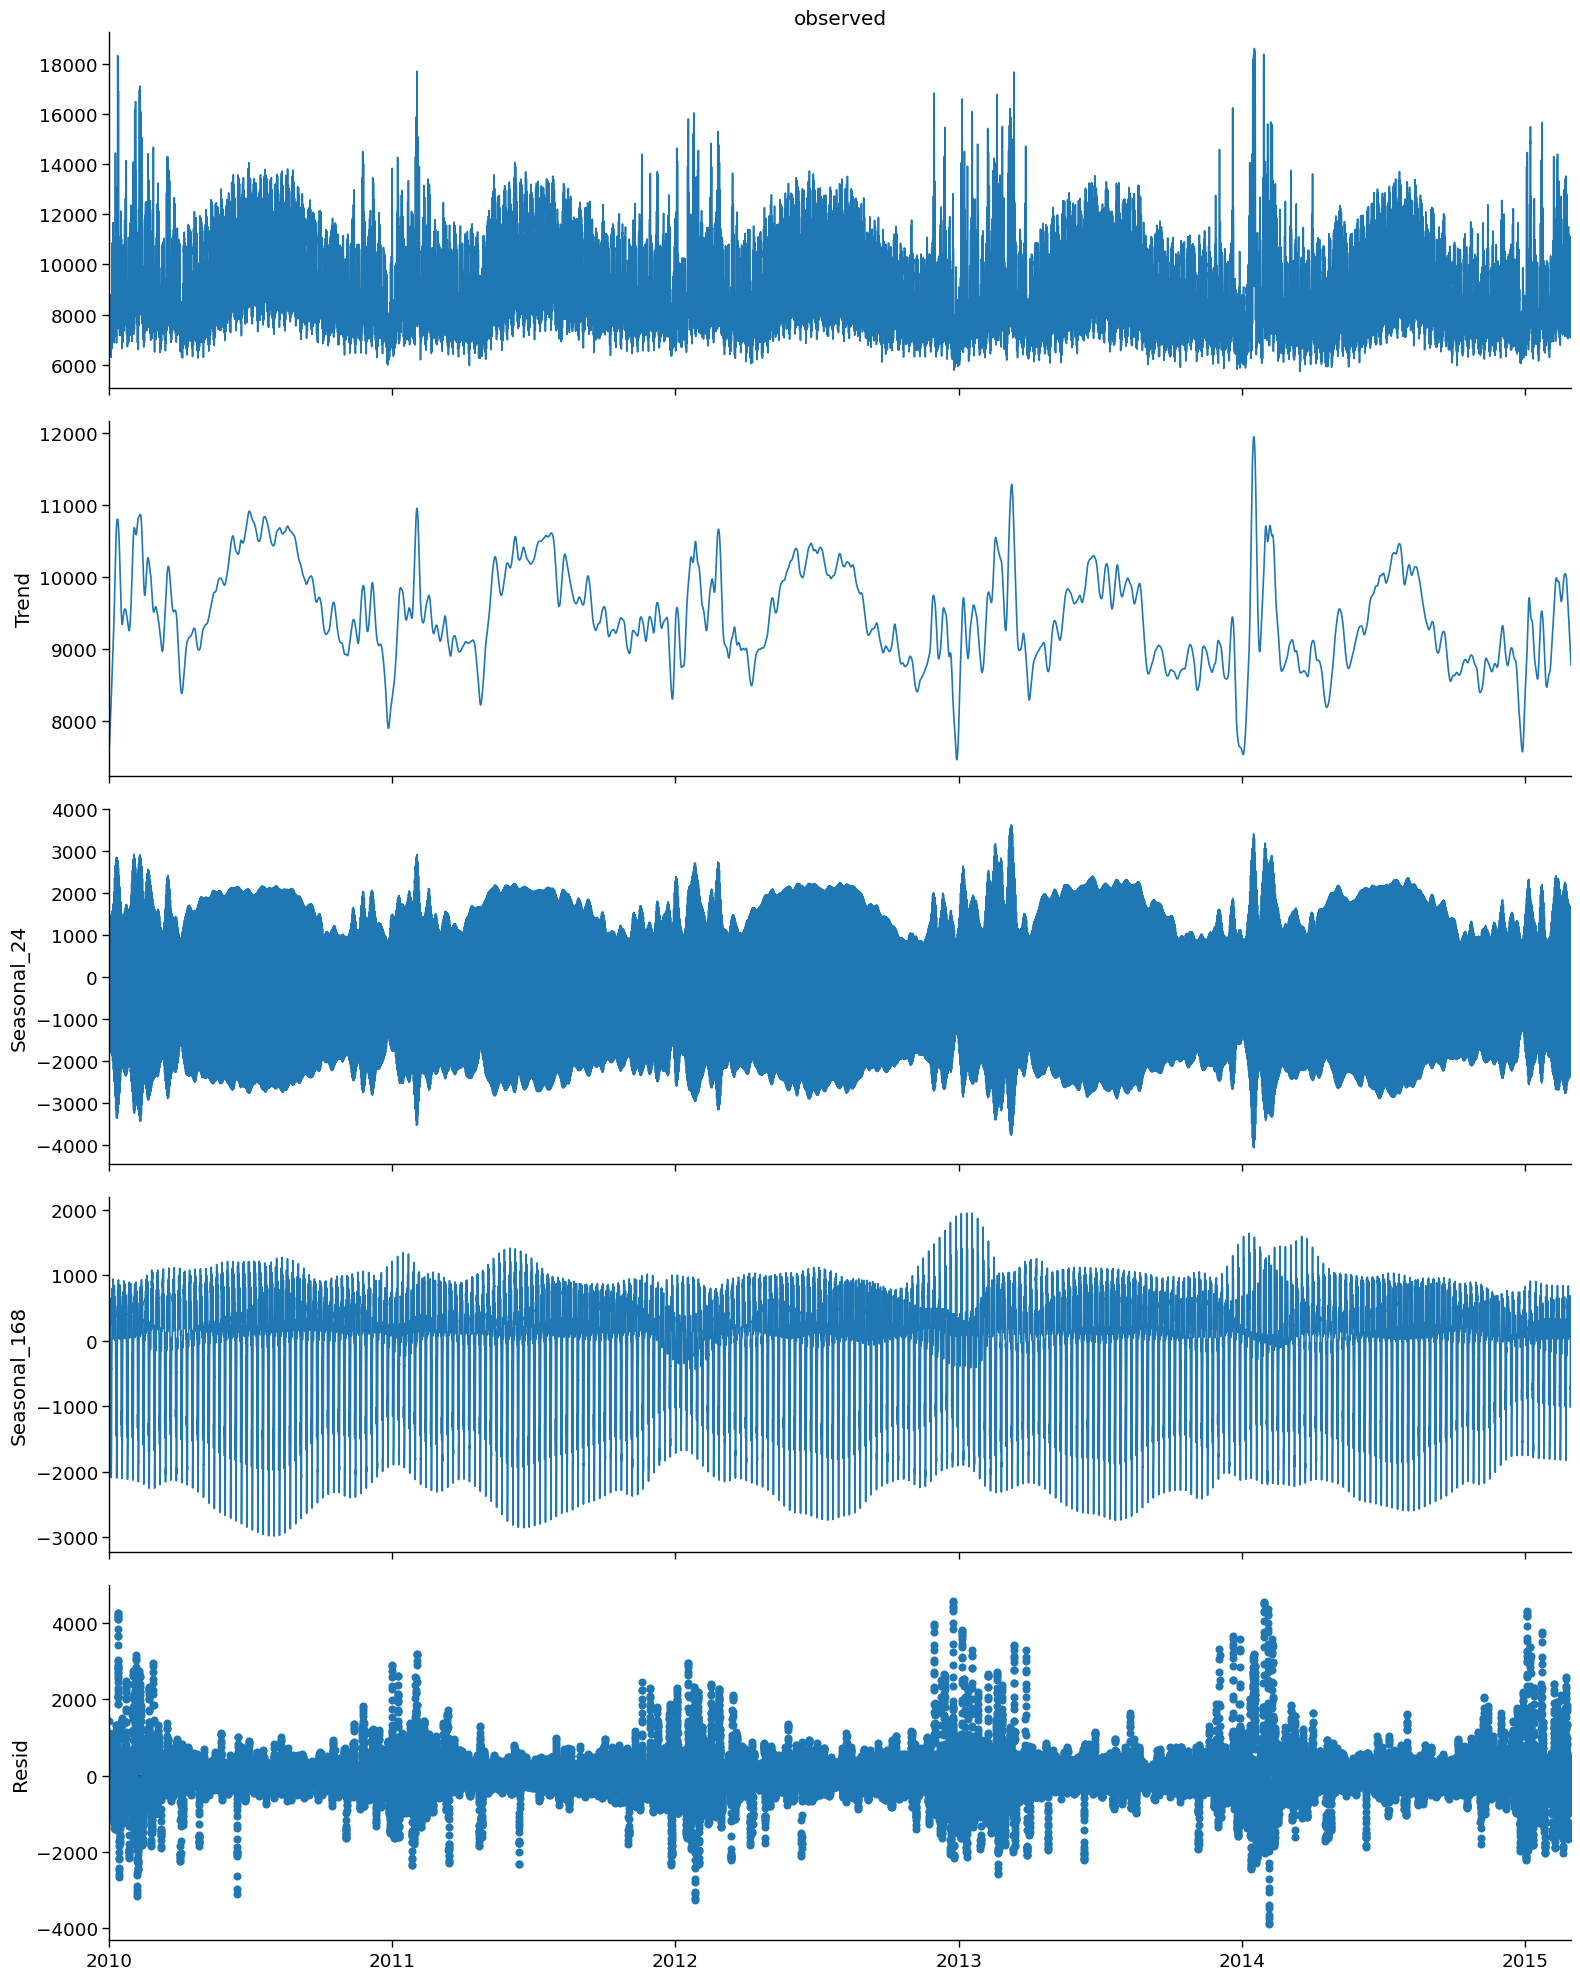

In [19]:
plt.rc("figure", figsize=(16, 20))
plt.rc("font", size=13)
fig = res.plot()

In [20]:
result = (
    res.trend # The trend component from MSTL.
    .rolling(window=24*7) # Pick window size.
    .agg(["mean", exponential_weighted_mean]) # Pick statistics.
    .shift(freq="1H") # Lag by 1 hour to avoid data leakage.  
).add_prefix("demand_window_168_")

# Join the window features back to the trend data
df = res.trend.to_frame().join(result, how='left')
df

,trend,demand_window_168_mean,demand_window_168_exponential_weighted_mean
date_time,,,
2010-01-01 00:00:00,"7,672.0165",NaN,NaN
2010-01-01 01:00:00,"7,683.0919",NaN,NaN
2010-01-01 02:00:00,"7,694.1771",NaN,NaN
2010-01-01 03:00:00,"7,705.2721",NaN,NaN
2010-01-01 04:00:00,"7,716.3771",NaN,NaN
...,...,...,...
2015-02-28 19:00:00,"8,817.7859","9,541.0623","8,999.6261"
2015-02-28 20:00:00,"8,808.7363","9,533.7759","8,990.5230"
2015-02-28 21:00:00,"8,799.6941","9,526.4395","8,981.4225"


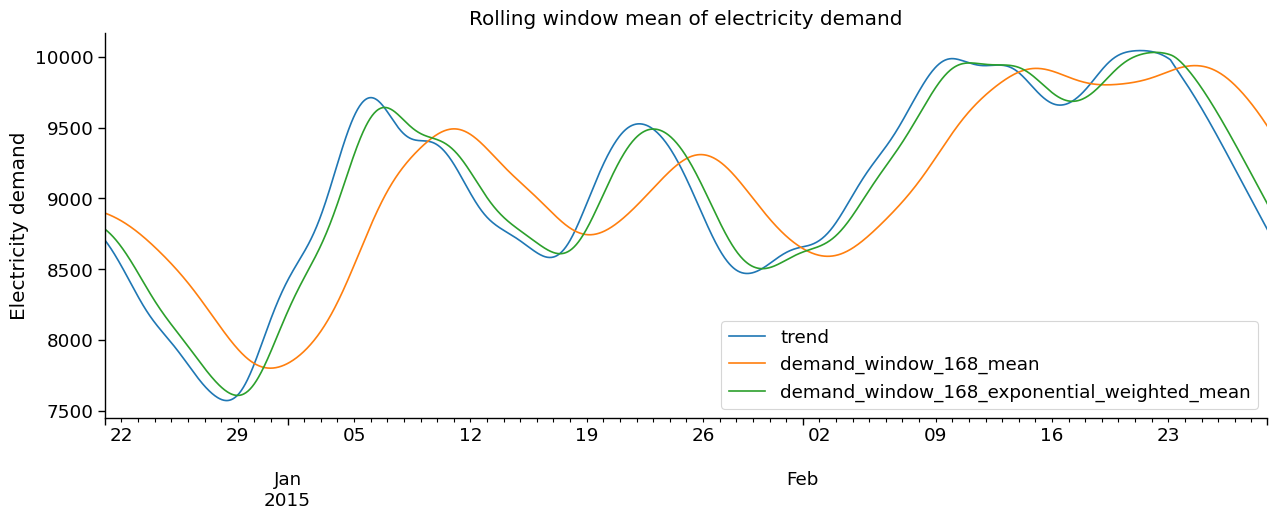

In [28]:
cols = ["trend", "demand_window_168_mean", "demand_window_168_exponential_weighted_mean"]

NUM_WEEKS = 10
ax = (
    df.iloc[-24 * 7 * NUM_WEEKS :] # Let's look at the last 2 weeks of data
        .loc[:, cols] # Filter to columns of interest
        .plot(figsize=(15,5))
    )  

ax.set_title("Rolling window mean of electricity demand")
ax.set_ylabel("Electricity demand")
ax.set_xlabel("")

plt.show()